# Подготовка окружения

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import joblib

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 20)

# Загрузка подготовленных датасетов

In [19]:
player_season_df = pd.read_csv("player_season_final.csv")
player_game_df = pd.read_csv("player_game_final.csv")

print("Player–Season shape:", player_season_df.shape)
print("Player–Game shape:", player_game_df.shape)

Player–Season shape: (28237, 10)
Player–Game shape: (1183996, 10)


# Первичная проверка данных

In [20]:
display(player_season_df.head())

,PTS,MP_per_game,AST,TRB,eFG%,3P%,FT%,TOV,PF,Age
0,458.0,15.873016,176.0,153.0,0.279,0.0,0.705,51.0,217.0,31.0
1,279.0,20.408163,109.0,153.0,0.372,0.0,0.708,51.0,99.0,29.0
2,438.0,14.925373,140.0,153.0,0.349,0.0,0.698,51.0,192.0,25.0
3,63.0,66.666667,20.0,153.0,0.256,0.0,0.559,51.0,29.0,24.0
4,59.0,76.923077,20.0,153.0,0.256,0.0,0.548,51.0,27.0,24.0


In [21]:
display(player_game_df.head())

,minutes,PTS_per_min,AST_per_min,REB_per_min,FG_PCT,FG3_PCT,FT_PCT,TOV_per_min,PF_per_min,PLUS_MINUS
0,38,0.500000,0.236842,0.078947,0.0,0.0,0.0,0.026316,0.078947,0.0
1,23,0.434783,0.130435,0.130435,0.0,0.0,0.4,0.043478,0.043478,0.0
2,3,1.333333,0.000000,1.000000,0.0,0.0,0.0,0.333333,1.000000,0.0
3,16,0.250000,0.125000,0.187500,0.0,0.0,0.0,0.062500,0.187500,0.0
4,27,0.148148,0.000000,0.333333,0.0,0.0,0.0,0.037037,0.148148,0.0


# Исходные данные для моделирования

В данном блокноте используются предварительно очищенные и агрегированные наборы данных уровня «игрок–сезон» и «игрок–матч», полученные на этапе разведочного анализа данных. Данные не содержат пропусков и мультиколлинеарных признаков и готовы к этапам feature engineering и построения базовых моделей машинного обучения.

# Feature Engineering (Player–Season)

## Производные признаки эффективности

In [22]:
season_fe = player_season_df.copy()

season_fe["AST_to_TOV"] = season_fe["AST"] / season_fe["TOV"].replace(0, pd.NA)

season_fe = season_fe.dropna()
season_fe.head()

,PTS,MP_per_game,AST,TRB,eFG%,3P%,FT%,TOV,PF,Age,AST_to_TOV
0,458.0,15.873016,176.0,153.0,0.279,0.0,0.705,51.0,217.0,31.0,3.45098
1,279.0,20.408163,109.0,153.0,0.372,0.0,0.708,51.0,99.0,29.0,2.137255
2,438.0,14.925373,140.0,153.0,0.349,0.0,0.698,51.0,192.0,25.0,2.745098
3,63.0,66.666667,20.0,153.0,0.256,0.0,0.559,51.0,29.0,24.0,0.392157
4,59.0,76.923077,20.0,153.0,0.256,0.0,0.548,51.0,27.0,24.0,0.392157


**Интерпретация признаков:**

* `AST_to_TOV` — баланс созидательных действий и ошибок

## Итоговый набор признаков и целевая переменная

In [23]:
features_season = [
    "MP_per_game",
    "AST",
    "TRB",
    "3P%",
    "TOV",
    "PF",
    "AST_to_TOV"
]

target_season = "PTS"

X_season = season_fe[features_season]
y_season = season_fe[target_season]

X_season.shape, y_season.shape

((27534, 7), (27534,))

## Контроль распределений новых признаков

In [24]:
season_fe["AST_to_TOV"].describe()

,AST_to_TOV
count,27534.0
unique,9250.0
top,1.0
freq,766.0


## Вывод:

В результате этапа feature engineering были сформированы производные признаки, позволяющие отделить эффективность игрока от объёма игрового времени и оценить баланс между результативными и ошибочными действиями. Полученный набор признаков обеспечивает информативную и интерпретируемую основу для построения базовых моделей прогнозирования сезонной результативности игроков.

# Feature Engineering (Player–Game)

## Производные признаки

In [10]:
game_fe = player_game_df.copy()

game_fe["USAGE_PROXY"] = (
    game_fe["PTS_per_min"]
    + game_fe["AST_per_min"]
    + game_fe["REB_per_min"]
)

game_fe.head()

,minutes,PTS_per_min,AST_per_min,REB_per_min,FG_PCT,FG3_PCT,FT_PCT,TOV_per_min,PF_per_min,PLUS_MINUS,USAGE_PROXY
0,38,0.500000,0.236842,0.078947,0.0,0.0,0.0,0.026316,0.078947,0.0,0.815789
1,23,0.434783,0.130435,0.130435,0.0,0.0,0.4,0.043478,0.043478,0.0,0.695652
2,3,1.333333,0.000000,1.000000,0.0,0.0,0.0,0.333333,1.000000,0.0,2.333333
3,16,0.250000,0.125000,0.187500,0.0,0.0,0.0,0.062500,0.187500,0.0,0.562500
4,27,0.148148,0.000000,0.333333,0.0,0.0,0.0,0.037037,0.148148,0.0,0.481481


## Целевая переменная

In [11]:
target_game_reg = "PLUS_MINUS"

## Итоговый набор признаков

In [12]:
features_game = [
    "minutes",
    "PTS_per_min",
    "AST_per_min",
    "REB_per_min",
    "FG_PCT",
    "FG3_PCT",
    "FT_PCT",
    "TOV_per_min",
    "PF_per_min",
    "USAGE_PROXY"
]

X_game = game_fe[features_game]
y_game = game_fe[target_game_reg]

X_game.shape, y_game.shape

((1183996, 10), (1183996,))

## Вывод:

Для набора данных уровня «игрок–матч» feature engineering выполнялся на основе ранее нормализованных показателей, что исключает повторное дублирование счётчиков и обеспечивает согласованность признакового пространства. Дополнительный агрегированный признак вовлечённости позволяет учитывать совокупный вклад игрока в атакующие действия в рамках одного матча.

# Baseline Models (Player–Season)

## Подготовка данных

In [30]:
X = X_season.copy()
y = y_season.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((22027, 7), (5507, 7))

## Baseline 1 — Линейная регрессия

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, r2_lr

(145.05109562756564, 0.8056837206657416)

## Baseline 2 — Random Forest Regressor

In [33]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, r2_rf

(99.2307393914345, 0.8958164006110236)

## Baseline 3 — Gradient Boosting Regressor

In [35]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mae_gbr, r2_gbr

(102.97753916601783, 0.8923935430718143)

## Сравнение baseline-моделей

In [36]:
baseline_season_results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Random Forest",
        "Gradient Boosting"
    ],
    "MAE": [
        mae_lr,
        mae_rf,
        mae_gbr
    ],
    "R2": [
        r2_lr,
        r2_rf,
        r2_gbr
    ]
})

baseline_season_results

,Model,MAE,R2
0,Linear Regression,145.051096,0.805684
1,Random Forest,99.230739,0.895816
2,Gradient Boosting,102.977539,0.892394


## Hyperparameter Tuning (GridSearchCV)

## Random Forest

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid_rf_small = {
    "n_estimators": [200, 400],
    "max_depth": [10, None],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf_small,
    scoring={"MAE": mae_scorer, "R2": "r2"},
    refit="R2",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 400}


### Оценка лучшей модели



In [41]:
best_rf = grid_rf.best_estimator_
pred_rf = best_rf.predict(X_test)

print("Best RF params:", grid_rf.best_params_)
print("Test MAE:", mean_absolute_error(y_test, pred_rf))
print("Test R2:", r2_score(y_test, pred_rf))

Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 400}
Test MAE: 97.98095552128852
Test R2: 0.8979020515530085


## Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

gbr = GradientBoostingRegressor(random_state=42)

param_grid_gbr = {
    "n_estimators": [200, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0],
}

grid_gbr = GridSearchCV(
    gbr,
    param_grid=param_grid_gbr,
    scoring={"MAE": mae_scorer, "R2": "r2"},
    refit="R2",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_gbr.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'n_estimators': [200, 500], 'subsample': [0.8, 1.0]},
             refit='R2',
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'R2': 'r2'},
             verbose=1)

### Оценка лучшей модели

In [43]:
best_gbr = grid_gbr.best_estimator_
pred_gbr = best_gbr.predict(X_test)

print("Best GBR params:", grid_gbr.best_params_)
print("Test MAE:", mean_absolute_error(y_test, pred_gbr))
print("Test R2:", r2_score(y_test, pred_gbr))

Best GBR params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Test MAE: 100.59874251456066
Test R2: 0.8947204478136297


## Сравнение baseline-моделей

In [45]:
from sklearn.metrics import mean_absolute_error, r2_score

metrics_summary = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "MAE": mean_absolute_error(y_test, y_pred_lr),
        "R2": r2_score(y_test, y_pred_lr),
    },
    {
        "Model": "Random Forest (baseline)",
        "MAE": mean_absolute_error(y_test, y_pred_rf),
        "R2": r2_score(y_test, y_pred_rf),
    },
    {
        "Model": "Gradient Boosting (baseline)",
        "MAE": mean_absolute_error(y_test, y_pred_gbr),
        "R2": r2_score(y_test, y_pred_gbr),
    },
    {
        "Model": "Random Forest (tuned)",
        "MAE": mean_absolute_error(y_test, best_rf.predict(X_test)),
        "R2": r2_score(y_test, best_rf.predict(X_test)),
    },
    {
        "Model": "Gradient Boosting (tuned)",
        "MAE": mean_absolute_error(y_test, best_gbr.predict(X_test)),
        "R2": r2_score(y_test, best_gbr.predict(X_test)),
    },
])

metrics_summary.sort_values("R2", ascending=False)

,Model,MAE,R2
3,Random Forest (tuned),97.980956,0.897902
1,Random Forest (baseline),99.230739,0.895816
4,Gradient Boosting (tuned),100.598743,0.894720
2,Gradient Boosting (baseline),102.977539,0.892394
0,Linear Regression,145.051096,0.805684


## Вывод:

Сравнение моделей показало, что наилучшее качество прогнозирования сезонной результативности демонстрирует настроенный Random Forest, обеспечивающий минимальную ошибку и наибольшее значение коэффициента детерминации. Настройка гиперпараметров даёт стабильный, но умеренный прирост качества для ансамблевых моделей, тогда как линейная регрессия существенно уступает им, что подтверждает нелинейный характер зависимостей в данных.

# Baseline Models (Player–Game)

## Подготовка данных

In [46]:
features_game = [
    "minutes",
    "PTS_per_min",
    "AST_per_min",
    "REB_per_min",
    "FG_PCT",
    "FG3_PCT",
    "FT_PCT",
    "TOV_per_min",
    "PF_per_min",
    "USAGE_PROXY"
]

target_game = "PLUS_MINUS"

X_game = game_fe[features_game]
y_game = game_fe[target_game]

Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_game, y_game, test_size=0.2, random_state=42
)

Xg_train.shape, Xg_test.shape

((947196, 10), (236800, 10))

## Baseline 1 — Linear Regression

In [47]:
lr_game = LinearRegression()
lr_game.fit(Xg_train, yg_train)

yg_pred_lr = lr_game.predict(Xg_test)

mae_lr_game = mean_absolute_error(yg_test, yg_pred_lr)
r2_lr_game = r2_score(yg_test, yg_pred_lr)

mae_lr_game, r2_lr_game

(4.924829740110109, 0.045411657743841594)

## Baseline 2 — Random Forest Regressor

In [48]:
rf_game = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_game.fit(Xg_train, yg_train)
yg_pred_rf = rf_game.predict(Xg_test)

mae_rf_game = mean_absolute_error(yg_test, yg_pred_rf)
r2_rf_game = r2_score(yg_test, yg_pred_rf)

mae_rf_game, r2_rf_game

(4.7320424552825235, 0.09314257283274208)

## Baseline 3 — Gradient Boosting Regressor

In [49]:
gbr_game = GradientBoostingRegressor(random_state=42)
gbr_game.fit(Xg_train, yg_train)

yg_pred_gbr = gbr_game.predict(Xg_test)

mae_gbr_game = mean_absolute_error(yg_test, yg_pred_gbr)
r2_gbr_game = r2_score(yg_test, yg_pred_gbr)

mae_gbr_game, r2_gbr_game

(4.810506443709022, 0.0878472441080771)

## Сравнение baseline-моделей

In [50]:
metrics_game = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "MAE": mae_lr_game,
        "R2": r2_lr_game,
    },
    {
        "Model": "Random Forest",
        "MAE": mae_rf_game,
        "R2": r2_rf_game,
    },
    {
        "Model": "Gradient Boosting",
        "MAE": mae_gbr_game,
        "R2": r2_gbr_game,
    },
])

metrics_game.sort_values("R2", ascending=False)

,Model,MAE,R2
1,Random Forest,4.732042,0.093143
2,Gradient Boosting,4.810506,0.087847
0,Linear Regression,4.924830,0.045412


## Вывод:

Для данных уровня «игрок–матч» все базовые модели демонстрируют низкие значения коэффициента детерминации, что отражает высокую вариативность и стохастичность индивидуальных игровых показателей в отдельных матчах. Ансамблевые модели (Random Forest и Gradient Boosting) лишь незначительно превосходят линейную регрессию, что указывает на ограниченную предсказуемость показателя PLUS_MINUS на уровне одного матча.

# Feature Importance

## Random Forest (Player–Season)

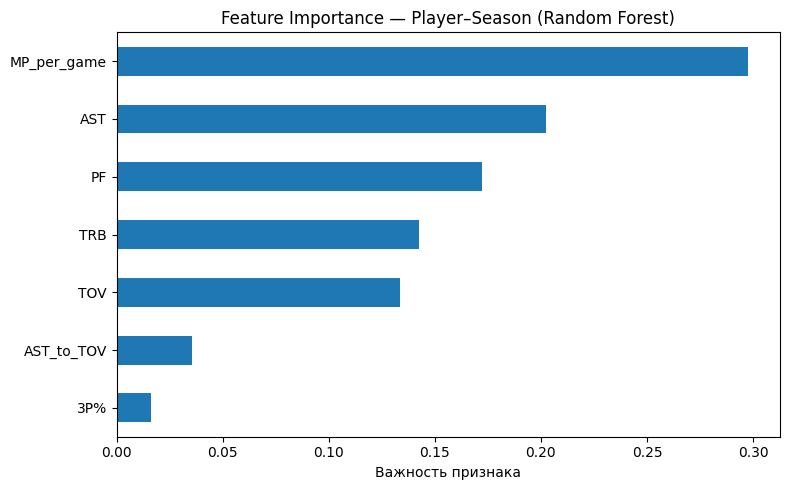

,0
MP_per_game,0.297838
AST,0.202546
PF,0.172128
TRB,0.142395
TOV,0.133397
AST_to_TOV,0.035724
3P%,0.015971


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

fi_season = pd.Series(
    best_rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
fi_season.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature Importance — Player–Season (Random Forest)")
plt.xlabel("Важность признака")
plt.tight_layout()
plt.show()

fi_season.head(10)

## Вывод:

Наибольший вклад в прогноз сезонной результативности вносят показатели игрового времени и вовлечённости в командные действия (минуты на матч, передачи, подборы и персональные фолы). Это подтверждает, что сезонная эффективность в первую очередь определяется объёмом участия игрока в игре, а не отдельными показателями точности.

## Random Forest (Player–Game)

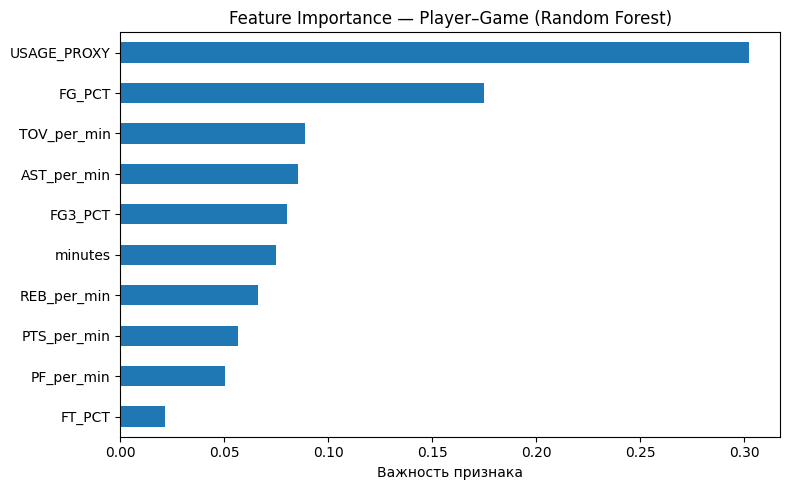

,0
USAGE_PROXY,0.302103
FG_PCT,0.174910
TOV_per_min,0.088678
AST_per_min,0.085356
FG3_PCT,0.079879
minutes,0.074904
REB_per_min,0.066076
PTS_per_min,0.056761
PF_per_min,0.050140
FT_PCT,0.021194


In [52]:
fi_game = pd.Series(
    rf_game.feature_importances_,
    index=Xg_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
fi_game.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature Importance — Player–Game (Random Forest)")
plt.xlabel("Важность признака")
plt.tight_layout()
plt.show()

fi_game.head(10)

## Вывод:

Для матчевого уровня ключевыми факторами являются прокси-показатели использования игрока и эффективность бросков, однако вклад отдельных признаков распределён более равномерно. Это отражает высокий уровень вариативности и зависимость индивидуального вклада игрока от контекста конкретного матча.

## Обобщающий вывод

Анализ важности признаков подтверждает принципиальное различие между сезонной и матчевой динамикой эффективности игроков, что обосновывает раздельное моделирование этих уровней данных.

# Сохранение лучших моделей

In [54]:
joblib.dump(best_rf, "random_forest_player_season_tuned.joblib")

['random_forest_player_season_tuned.joblib']

In [56]:
joblib.dump(rf_game, "random_forest_player_game.joblib")

['random_forest_player_game.joblib']